# Transfer Learning Workflow

In [1]:
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.optimizers import RMSprop


## 1. Data Preparation & Augmentation

In [2]:
TRAINING_DIR = "/Users/henriquerenda/Documents/LearningComputerVision/data/CarxTruck/train"
VALIDATION_DIR = "/Users/henriquerenda/Documents/LearningComputerVision/data/CarxTruck/valid"


train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(128, 128),
                                                    color_mode="rgb",
                                                    shuffle=True,
                                                    seed=42)



validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='binary',
                                                              target_size=(128, 128),
                                                              color_mode="rgb",
                                                              shuffle=True,
                                                              seed=42)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


## 2. Data Augmentation

Found 5117 images belonging to 2 classes.
Found 5051 images belonging to 2 classes.


## 3. Modelling

In [4]:
#1. Use a pre-trained model (e.g. InceptionV3)
base_model = keras.applications.InceptionV3(input_shape=(128, 128, 3),
                                include_top=False,
                                weights=None)

#2. freeze the base model
base_model.trainable = False

In [5]:
inputs = keras.Input(shape=(128, 128, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

In [10]:
# compile the model
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

/Users/henriquerenda/miniforge3/envs/MachineLearningEnv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [12]:
# train the model (adjust the number of epochs from 1 to improve performance)
with tensorflow.device('/device:GPU:0'):
    history = model.fit(
                train_generator,
                validation_data=validation_generator,
                epochs=15,
                verbose=1)

Epoch 1/15
52/52 [==============================] - 38s 688ms/step - loss: 6.4992 - binary_accuracy: 0.5787 - val_loss: 6.5016 - val_binary_accuracy: 0.5785
Epoch 2/15
52/52 [==============================] - 35s 674ms/step - loss: 6.4992 - binary_accuracy: 0.5787 - val_loss: 6.5016 - val_binary_accuracy: 0.5785
Epoch 3/15
 5/52 [=>............................] - ETA: 16s - loss: 6.2934 - binary_accuracy: 0.5920

KeyboardInterrupt: 

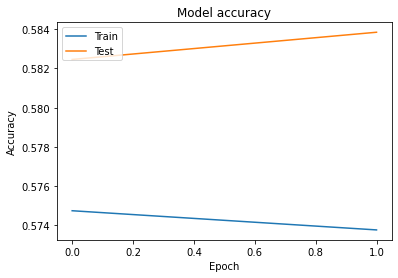

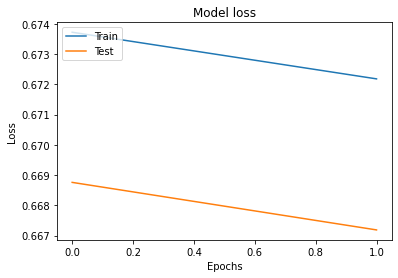

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()